In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

/Users/fernandokenjisakabe/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading pipeline params.
DATA_PATH = Path('data')
FILENAME_STOP = 'stop_90_diff_quat.csv'
FILENAME_0 = '0_90_diff_quat.csv'
FILENAME_90 = '90_90_diff_quat.csv'
FILENAME_180 = '180_90_diff_quat.csv'
FILENAME_270 = '270_90_diff_quat.csv'

# # Loading pipeline params.
# DATA_PATH = Path('data')
# FILENAME_STOP = 'stop.csv'
# FILENAME_0 = 'm_0.csv'
# FILENAME_90 = 'm_90.csv'
# FILENAME_180 = 'm_180.csv'
# FILENAME_270 = 'm_270.csv'


NUM_TIMESTEPS = 6
IGNORE_FRACTION = 0.1
TEST_FRACTION = 0.25

# Training params.
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

In [3]:
def load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    num_timesteps,
    ignore_fraction,
    test_fraction,
):

    def read_and_prepare_data(
        path,
        class_,
        num_timesteps,
        ignore_fraction,
        test_fraction,
    ):

        def split_temporally(X, test_fraction):
            num_samples = X.shape[0]
            num_train = int(num_samples * (1.0 - test_fraction))
            X_train, X_test = X[:num_train], X[num_train:]
            return X_train, X_test

        def transform_into_sequences(X, num_timesteps):
            num_samples = X.shape[0]
            X_seq = []
            for k in range(num_samples - num_timesteps + 1):
                X_seq.append(X[k:(k + num_timesteps)])
            X_seq = np.array(X_seq)
            y_seq = class_ * np.ones((X_seq.shape[0], 1))
            return X_seq, y_seq

        X = pd.read_csv(path).values
        X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

        # Ignore beginning and end.
        num_samples = X.shape[0]
        num_ignore = int(ignore_fraction * num_samples)
        X = X[num_ignore:-num_ignore]

        # Split X temporally.
        X_train, X_test = split_temporally(X, test_fraction)

        # Transform X into short sequences.
        X_train, y_train = transform_into_sequences(X_train, num_timesteps)
        X_test, y_test = transform_into_sequences(X_test, num_timesteps)

        return X_train, y_train, X_test, y_test

    def shuffle_data(X, y):
        idx = np.arange(len(X))
        default_rng().shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        return X_shuffled, y_shuffled

    X_train_stop, y_train_stop, X_test_stop, y_test_stop = \
        read_and_prepare_data(
            path_stop,
            0.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_0, y_train_0, X_test_0, y_test_0 = \
        read_and_prepare_data(
            path_0,
            1.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train_90, y_train_90, X_test_90, y_test_90 = \
        read_and_prepare_data(
            path_90,
            2.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_180, y_train_180, X_test_180, y_test_180 = \
        read_and_prepare_data(
            path_180,
            3.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_270, y_train_270, X_test_270, y_test_270 = \
        read_and_prepare_data(
            path_270,
            4.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
    y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
    X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
    y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)

    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)

    return X_train, X_test, y_train, y_test


path_stop = Path(DATA_PATH, FILENAME_STOP)
path_0 = Path(DATA_PATH, FILENAME_0)
path_90 = Path(DATA_PATH, FILENAME_90)
path_180 = Path(DATA_PATH, FILENAME_180)
path_270 = Path(DATA_PATH, FILENAME_270)

X_train, X_test, y_train, y_test = load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    NUM_TIMESTEPS,
    IGNORE_FRACTION,
    TEST_FRACTION,
)

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100773, 6, 14), (100773, 1), (33575, 6, 14), (33575, 1))

In [5]:
X_test[60].shape


(6, 14)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(256, kernel_size=(3, 3),
               strides=(1, 1), padding="same",
               activation="selu", input_shape=[6, 14, 1]))

CNN.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                     padding="valid"))

# Add another pair of Conv2D and MaxPooling2D for more model depth,
# followed by the flatten and multiple dense layers

# CNN.add(Conv2D(64, kernel_size=(3, 3),
#                strides=(1, 1), padding="same",
#                activation="selu"))

# CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
#                      padding="valid"))

CNN.add(Flatten())

CNN.add(Dense(64, activation='selu'))
CNN.add(Dense(32, activation='selu'))
CNN.add(Dense(5, activation='softmax'))

CNN.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 6, 14, 256)        2560      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 6, 256)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                196672    
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                    

In [60]:
from numpy import *
where_are_NaNsx = isnan(X_train)
X_train[where_are_NaNsx] = 0

where_are_NaNsy = isnan(y_train)
y_train[where_are_NaNsy] = 0

where_are_NaNsxt = isnan(X_test)
X_test[where_are_NaNsxt] = 0

where_are_NaNsyt = isnan(y_test)
y_test[where_are_NaNsyt] = 0

In [62]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = CNN.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/10
394/394 [==============================] - 23s 57ms/step - loss: 0.0325 - accuracy: 0.9903 - val_loss: 0.0981 - val_accuracy: 0.9757
Epoch 2/10
394/394 [==============================] - 22s 56ms/step - loss: 0.0204 - accuracy: 0.9943 - val_loss: 0.0483 - val_accuracy: 0.9889
Epoch 3/10
394/394 [==============================] - 22s 56ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0504 - val_accuracy: 0.9875
Epoch 4/10
394/394 [==============================] - 22s 56ms/step - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.0477 - val_accuracy: 0.9902
Epoch 5/10
394/394 [==============================] - 22s 56ms/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.0526 - val_accuracy: 0.9898
Epoch 6/10
394/394 [==============================] - 22s 57ms/step - loss: 0.0119 - accuracy: 0.9971 - val_loss: 0.0344 - val_accuracy: 0.9923
Epoch 7/10
394/394 [==============================] - 23s 58ms/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.0663 - val_accuracy:

In [63]:
# from functools import partial



# _, num_time, num_feat = X_train.shape

# activation = 'selu'

# DefaultConv1D = partial(
#     keras.layers.Conv1D,
#     kernel_size=1,
#     activation=activation,
#     padding="valid",
# )

# model = keras.models.Sequential([
#     DefaultConv1D(4 * num_feat, kernel_size=2, input_shape=[num_time, num_feat]),
#     keras.layers.BatchNormalization(),
#     DefaultConv1D(num_feat, kernel_size=2),
#     keras.layers.Flatten(),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_time * num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(5, activation='softmax'),
# ])

# optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=optimizer,
#     metrics=['accuracy'],
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_test, y_test),
#     verbose=1,
# )

In [64]:

# import tensorflow as tf

# # define the input shape
# input_shape = (6, 14)

# # create the input placeholder for the model
# input_data = tf.keras.Input(shape=input_shape)

# # reshape input data
# input_data_reshaped = tf.keras.layers.Reshape((6, 14, 1))(input_data)

# # define the convolutional layer
# conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_data_reshaped)

# # add maxpooling layer
# maxpooling = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)


# reshaped = tf.keras.layers.Reshape((2, 6*32))(maxpooling)

# # define the recurrent layer
# rnn = tf.keras.layers.GRU(units=64, return_sequences=True)(reshaped)

# # define the fully connected layers


# fc1 = tf.keras.layers.Dense(units=64, activation='relu')(rnn)
# fc2 = tf.keras.layers.Dense(units=5, activation='softmax')(fc1)

# # define the model
# model = tf.keras.Model(inputs=input_data, outputs=fc2)

# # compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [65]:
# import tensorflow as tf

# # define the input shape
# input_shape = (6, 14)

# # create the input placeholder for the model
# input_data = tf.keras.Input(shape=input_shape)

# # reshape input data
# input_data_reshaped = tf.keras.layers.Reshape((6, 14, 1))(input_data)

# # define the convolutional layer
# conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_data_reshaped)

# # add maxpooling layer
# maxpooling = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)


# reshaped = tf.keras.layers.Reshape((2, 6*32))(maxpooling)

# # define the recurrent layer
# rnn = tf.keras.layers.GRU(units=64, return_sequences=True)(reshaped)

# # add flatten layer
# flatten = tf.keras.layers.Flatten()(rnn)

# # define the fully connected layers
# fc1 = tf.keras.layers.Dense(units=64, activation='relu')(flatten)
# fc2 = tf.keras.layers.Dense(units=5, activation='softmax')(fc1)

# # define the model
# model = tf.keras.Model(inputs=input_data, outputs=fc2)

# # compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])

In [66]:
# history=model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

In [67]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

KeyError: 'categorical_accuracy'

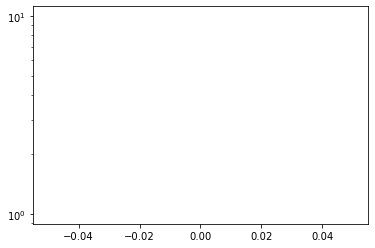

In [68]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.yscale('log')

In [69]:
y_pred = CNN.predict(X_test)
# y_pred = model.predict(X_test)

1050/1050 [==============================] - 3s 3ms/step


In [76]:
y_pred

array([3, 0, 1, ..., 0, 3, 3])

In [77]:
y_pred= np.argmax(y_pred, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [78]:
y_pred

array([3, 0, 1, ..., 0, 3, 3])

In [79]:
y_pred[0]

3

In [80]:
df = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred.ravel().astype(int).tolist(),
})

In [81]:
pd.crosstab(df['y_test'], df['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,14100,133,0,10,152
1,42,4753,0,0,0
2,0,0,4795,0,0
3,0,0,0,4795,0
4,0,0,0,0,4795


In [82]:
# model.save('model.h5')

In [84]:
CNN.save('model_21_01_2023_stop_alterado_99.h5')